# Курсовая работа

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 

На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет для жестов рук. 

Для курсовой работы был использован свой датасет, где было смонтировано видео с каждым жестом. Для разметки и сбора данных была использована бибилиотека __mediapipe__.

Итогом работы стало, что сеть обучается на наших данных и в режиме просмотра видео (также в режиме онлайн) выводит на экране название знакомого ей жеста. При появлении жеста __'Palm'__ система делает скриншот и записывает картинку в папку, при появлении жеста __'Ok'__ система здоровается с человеком. Также по итогу работы сеть ведет журнал с записями знакомых ей жестов. 

__Загрузим все необходимые библиотеки и начнем:__

In [14]:
import cv2
import numpy as np
import pickle
import mediapipe as mp
import math
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim

from facenet_pytorch import MTCNN

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

Создадим функцию для десериализации видео с помощью модуля pickle

In [16]:
def load_data(name):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

Проверим оборудование

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Часть 1. Подготовка данных

Шаг 1. Загрузим данные

In [52]:
file_i = 'data__0'
file_ok = 'data__1'
file_palm = 'data__2'
file_thumb = 'data__3'

In [55]:
data_i = load_data(file_i)
data_ok = load_data(file_ok)
data_palm = load_data(file_palm)
data_thumb = load_data(file_thumb)

Шаг 2. Соединим массивы с данными

In [59]:
data_1 = np.vstack((data_i, data_ok))
data_2 = np.vstack((data_palm, data_thumb))
data = np.vstack((data_1, data_2))

Шаг 3. Перемешаем наш итоговый массив с данными

In [60]:
perm = np.random.permutation(len(data))
data = data[perm]

Посмотрим что получилось

In [61]:
data_i.shape, data_ok.shape, data_palm.shape, data_thumb.shape, data.shape

((1232, 64), (1302, 64), (1277, 64), (1281, 64), (5092, 64))

In [62]:
data

array([[ 4.05458391e-01,  5.14494717e-01, -6.18022314e-05, ...,
         4.75846380e-01, -4.51643705e-01,  3.00000000e+00],
       [ 3.97533625e-01,  5.49053490e-01, -4.11624787e-05, ...,
         3.44248593e-01, -1.48946017e-01,  1.00000000e+00],
       [ 6.18091464e-01,  6.69821143e-01, -6.42927116e-05, ...,
         5.63005924e-01,  8.60442072e-02,  3.00000000e+00],
       ...,
       [ 6.42363131e-01,  5.27218938e-01,  4.95112654e-05, ...,
         4.71172720e-01, -6.57133237e-02,  3.00000000e+00],
       [ 5.67390680e-01,  7.55060136e-01, -1.77461057e-04, ...,
         4.43612635e-01, -5.23953848e-02,  2.00000000e+00],
       [ 1.16367780e-01,  5.42504191e-01, -2.50578305e-04, ...,
         5.10196567e-01, -5.91915131e-01,  3.00000000e+00]])

Шаг 4. Создадим классы наших жестов

In [63]:
LABELS = ['I', 'Ok', 'Palm', 'Thumb']

Шаг 5. Разделим наши данные

In [64]:
X_data = data[:,:-1]
y_data = data[:,-1].astype('int64')
X_data.shape, y_data.shape

((5092, 63), (5092,))

Шаг 6. Создадим наш Dataloader

In [65]:
class Skeleton_Dataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data) 
       
    def __getitem__(self, idx):
        item = self.data[idx]        
        label = self.labels[idx]        
        return (item, label)

In [67]:
dataset = Skeleton_Dataset(X_data, y_data)

Будем использовать 75 % в тренировочную выборку, 25 - в тестовую 

In [85]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), int(0.25*len(dataset))])

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

## Часть 2. Создание модели

In [86]:
class ResNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
      
        self.output_dim = output_dim
        self.fc1 = torch.nn.Linear(input_dim, 256)
        self.elu1 = torch.nn.ELU(inplace=True)
        self.fc2 = torch.nn.Linear(256, 512)        
        self.elu2 = torch.nn.ELU(inplace=True)        
        self.dr1 = torch.nn.Dropout(0.5)
        self.fc3 = torch.nn.Linear(512, output_dim)
        self.sm = torch.nn.Softmax(dim=1)
        
        
    def forward(self, inputs):
        x = inputs
        x = self.fc1(x)
        x = self.elu1(x)
        x = self.fc2(x)
        x = self.elu2(x)        
        x = self.dr1(x)    
        x = self.fc3(x)        
        out = self.sm(x)
        
        return out

In [87]:
input_dim = 63
output_dim = len(LABELS)
net = ResNet(input_dim, output_dim)
net.to(device)

ResNet(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (elu1): ELU(alpha=1.0, inplace=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (elu2): ELU(alpha=1.0, inplace=True)
  (dr1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (sm): Softmax(dim=1)
)

In [88]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()

    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    
    return '%dm %ds' % (m, s)

## Часть 3. Обучение

In [89]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()
    
epochs = 2000
lr = 0.001

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [91]:
total_steps = len(train_loader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

2000 epochs, 15 total_steps per epoch


In [92]:
all_losses = []
start = time.time()
counter = 0
for epoch in range(epochs):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = net(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))
        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.3877  / I ✗ (Thumb)
epoch : 33 iter : 5 (0m 1s) 1.3816  / Ok ✓
epoch : 66 iter : 10 (0m 2s) 1.3701  / Ok ✗ (Thumb)
epoch : 100 iter : 0 (0m 4s) 1.3502  / Ok ✗ (I)
epoch : 133 iter : 5 (0m 5s) 1.3385  / Ok ✗ (Thumb)
epoch : 166 iter : 10 (0m 7s) 1.3212  / Ok ✗ (Palm)
epoch : 200 iter : 0 (0m 8s) 1.2891  / I ✓
epoch : 233 iter : 5 (0m 10s) 1.2384  / Thumb ✓
epoch : 266 iter : 10 (0m 11s) 1.1916  / Ok ✓
epoch : 300 iter : 0 (0m 12s) 1.1495  / Ok ✗ (Palm)
epoch : 333 iter : 5 (0m 14s) 1.0926  / Thumb ✓
epoch : 366 iter : 10 (0m 15s) 1.0359  / Ok ✓
epoch : 400 iter : 0 (0m 16s) 0.9814  / Ok ✓
epoch : 433 iter : 5 (0m 18s) 0.9215  / Palm ✓
epoch : 466 iter : 10 (0m 19s) 0.8857  / I ✓
epoch : 500 iter : 0 (0m 21s) 0.8642  / Palm ✓
epoch : 533 iter : 5 (0m 22s) 0.8435  / Thumb ✓
epoch : 566 iter : 10 (0m 24s) 0.8274  / I ✓
epoch : 600 iter : 0 (0m 25s) 0.8163  / Ok ✓
epoch : 633 iter : 5 (0m 26s) 0.8156  / Thumb ✗ (Palm)
epoch : 666 iter : 10 (0m 28s) 0.8064  / I ✓

Text(0.5, 1.0, 'losses vs. No. of epochs')

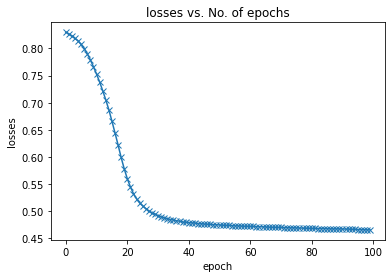

In [93]:
losses = [np.mean(loss) for loss in all_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [94]:
total = 0
right = 0
counter = 0

net.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = net(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   97.56480754124117


Сохраним нашу модель:

In [95]:
torch.save(net.state_dict(), 'model_2000_epochs.pth')

Загрузим модель:

In [96]:
net = ResNet(input_dim, output_dim).to(device)
net.load_state_dict(torch.load('model_2000_epochs.pth'))
net.eval()

ResNet(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (elu1): ELU(alpha=1.0, inplace=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (elu2): ELU(alpha=1.0, inplace=True)
  (dr1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (sm): Softmax(dim=1)
)

## 4. Прототип приложения для определения человека и жестов рук перед веб-камерой или по видео

In [99]:
# Функция рисования найденных параметров на кадре
def draw(frame, boxes, probs, landmarks):
    try:
        for box, prob, ld in zip(boxes, probs, landmarks):
            # Рисуем обрамляющий прямоугольник лица на кадре
            cv2.rectangle(frame,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          (240, 15, 201),
                          thickness=3)

    except Exception as e:
        pass
    return frame

In [110]:
# For video input:
# file_name = "121.mp4"
# cap = cv2.VideoCapture(file_name)  

# For webcam input:
cap = cv2.VideoCapture('http://192.168.1.2:8080/video') # В качестве веб-камеры использовал телефон  

mtcnn = MTCNN()
gesture_name = []
pre_char=''
current_char=''
count = 0

with mp_hands.Hands(
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75,
    max_num_hands=1) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            break
            # continue
            
        scale_percent = 50    
        width  = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)

        # dsize
        dsize = (width, height)    

        # resize image
        image = cv2.resize(image, dsize)
        try:        
            boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)                
            image = draw(image, boxes, probs, landmarks)        
        except:
            pass
                
        palm_vector_list = []
        
        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)      
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        results = hands.process(image)

        # Draw the hand mesh annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for n_point in range(len(results.multi_hand_landmarks[0].landmark)):
                    palm_vector_list.append(hand_landmarks.landmark[n_point].x)
                    palm_vector_list.append(hand_landmarks.landmark[n_point].y)                        
                    palm_vector_list.append(hand_landmarks.landmark[n_point].z)                
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS) 

            
            prob=torch.tensor(np.array(palm_vector_list), dtype=torch.float, device=device)
            prob=torch.reshape(prob, (1, X_data.shape[1]))
            
            result = net(prob)
            
            emotion = categoryFromOutput(result)[0]
            
            cv2.putText(image, 
                        emotion, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            
            current_char = emotion
            if current_char != pre_char:
                gesture_name.append(current_char)
                pre_char = current_char
                
                if current_char == 'Palm':
                    count += 1  
                    cv2.imwrite('screen/foto_' + str(current_char) + "_" + str(count) + '.jpg', image)

                if current_char == 'Thumb':
                    emotion = 'Hello'
                    cv2.putText(image,
                                emotion, (70, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            cv2.imshow('MediaPipe PalmMesh', image)

        else:
            emotion = 'No hand'
            cv2.putText(image, 
                        emotion, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            
            cv2.namedWindow('MediaPipe PalmMesh', cv2.WINDOW_NORMAL)
            cv2.imshow('MediaPipe PalmMesh', image)
              
            
        # if cv2.waitKey(5) & 0xFF == 27:
        #         break
    
        # For webcam work       
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break

cap.release()
cv2.destroyAllWindows()

In [111]:
# Журнал с распознанными жестами (gesture_name)
for gest in gesture_name:
    print(gest, end=',  ')

Palm,  I,  Palm,  I,  Palm,  Ok,  Palm,  Thumb,  I,  Thumb,  I,  Palm,  Thumb,  I,  Thumb,  Ok,  Thumb,  Ok,  Thumb,  Ok,  Thumb,  Ok,  Palm,  Thumb,  Palm,  Ok,  Palm,  Thumb,  I,  Thumb,  I,  Thumb,  I,  Thumb,  I,  Thumb,  I,  Thumb,  I,  Thumb,  I,  Thumb,  I,  Palm,  I,  Palm,  I,  Thumb,  I,  Palm,  I,  Thumb,  Palm,  I,  Thumb,  I,  Thumb,  I,  Palm,  I,  Thumb,  I,  Palm,  I,  Palm,  Ok,  Palm,  Thumb,  Ok,  I,  Thumb,  Palm,  Ok,  Palm,  Thumb,  I,  Palm,  